In [2]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Define the paths to the folders
data_path = './dataset'
folders = ['circle_images_d', 'circle_images_p', 'circle_images_t']

# Initialize lists to hold the images and labels
images = []
labels = []

# Loop through each folder and read the images
for label, folder in enumerate(folders):
    folder_path = os.path.join(data_path, folder)
    for filename in tqdm(os.listdir(folder_path)):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (360, 360))  # Resize images to 720x720
            images.append(img)
            labels.append(int(filename.split('_')[1].split('.')[0]))

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f'Training set size: {X_train.shape[0]}')
print(f'Testing set size: {X_test.shape[0]}')

100%|██████████| 1000/1000 [00:18<00:00, 52.73it/s]


Training set size: 2400
Testing set size: 600


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming images and labels are numpy arrays
# Convert them to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Permute to (N, C, H, W)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Ensure labels have shape (N, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Using device: cuda


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ComplexConvBlock(nn.Module):
    """
    Defines a complex convolutional block with depthwise separable convolutions, batch normalization,
    activation functions, Squeeze-and-Excitation (SE) block, and dropout for regularization.
    Ensures that the input and output shapes are identical.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, dropout_prob=0.1, reduction_ratio=16):
        super(ComplexConvBlock, self).__init__()
        
        # Depthwise separable convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
        # Squeeze-and-Excitation (SE) block
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(out_channels, out_channels // reduction_ratio, kernel_size=1)
        self.fc2 = nn.Conv2d(out_channels // reduction_ratio, out_channels, kernel_size=1)
        
        self.sigmoid = nn.Sigmoid()
        
        # Dropout layer
        self.dropout = nn.Dropout2d(dropout_prob)
        
        # Adjust channels if necessary for residual connection
        self.adjust_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        
        # Depthwise separable convolution with pointwise and activation
        out = self.depthwise(x)
        out = self.pointwise(out)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # Second convolutional layer with activation
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        # Squeeze-and-Excitation (SE) block
        se = self.global_avg_pool(out)
        se = self.fc1(se)
        se = F.relu(se)
        se = self.fc2(se)
        se = self.sigmoid(se)
        
        out = out * se  # Scale feature maps with SE block output
        
        # Dropout
        out = self.dropout(out)
        
        # Adjust channels for residual if necessary
        if self.adjust_channels:
            identity = self.adjust_channels(identity)
        
        out += identity  # Residual connection
        out = F.relu(out)
        return out

class SelectiveOmissionCNN(nn.Module):
    """
    Convolutional Neural Network model that allows selective omission of complex convolutional blocks
    during testing to evaluate their importance.
    """
    def __init__(self, input_channels=3, num_blocks=5):
        """
        Initializes the model.
        
        Args:
            input_channels (int): Number of input channels (e.g., 3 for RGB images).
            num_blocks (int): Number of convolutional blocks in the network.
            num_classes (int): Number of output classes for classification.
        """
        super(SelectiveOmissionCNN, self).__init__()
        self.num_blocks = num_blocks
        
        # First convolutional layer (always active)
        self.initial_conv = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)  # Output: 64 x 180 x 180
        self.initial_bn = nn.BatchNorm2d(64)
        self.initial_relu = nn.ReLU(inplace=True)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Output: 64 x 90 x 90
        
        # Create complex convolutional blocks
        self.blocks = nn.ModuleList([
            ComplexConvBlock(64, 64) for _ in range(num_blocks)
        ])
        
        # Final layers
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output: 64 x 1 x 1
        self.fc = nn.Linear(64, 1)
        
    def forward(self, x, skip_blocks=None):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, 360, 360).
            skip_blocks (list of int, optional): Indices of blocks to skip during the forward pass.
        
        Returns:
            torch.Tensor: Output tensor with class scores.
        """
        if skip_blocks is None:
            skip_blocks = []
        
        # Initial layers (always active)
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.initial_relu(x)
        x = self.initial_pool(x)  # Shape: (batch_size, 64, 90, 90)
        
        # Iterate through each complex convolutional block
        for idx, block in enumerate(self.blocks):
            if idx in skip_blocks:
                continue  # Skip this block
            x = block(x)  # Each block maintains shape (batch_size, 64, 90, 90)
        
        # Final layers
        x = self.global_pool(x)  # Shape: (batch_size, 64, 1, 1)
        x = torch.flatten(x, 1)  # Shape: (batch_size, 64)
        x = self.fc(x)  # Shape: (batch_size, num_classes)
        return x


In [5]:

model = SelectiveOmissionCNN().to(device)  # Move model to GPU

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Move data to the appropriate device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print average loss for each epoch
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    mae_loss = 0.0  # Additional metric for easier interpretation (MAE)
    with torch.no_grad():  # Disable gradient calculation for inference
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # MSE loss
            test_loss += loss.item()
            
            # Calculate MAE for easier interpretation
            mae_loss += torch.abs(outputs - labels).mean().item()
    
    avg_mse_loss = test_loss / len(test_loader)
    avg_mae_loss = mae_loss / len(test_loader)
    print(f"Test MSE Loss: {avg_mse_loss:.4f}, Test MAE Loss: {avg_mae_loss:.4f}")
    return avg_mse_loss, avg_mae_loss

# Set device and move model to device (e.g., "cuda" for GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train the model
train(model, train_loader, criterion, optimizer, device, epochs=100)



# Evaluate the model
evaluate(model, test_loader, criterion, device)


Epoch 1/100, Loss: 319782.8146
Epoch 2/100, Loss: 298491.9035
Epoch 3/100, Loss: 265052.0058
Epoch 4/100, Loss: 224320.7378
Epoch 5/100, Loss: 183043.3946
Epoch 6/100, Loss: 146428.3706
Epoch 7/100, Loss: 118437.7798
Epoch 8/100, Loss: 99746.9126
Epoch 9/100, Loss: 88866.5590
Epoch 10/100, Loss: 82658.9411
Epoch 11/100, Loss: 79639.1119
Epoch 12/100, Loss: 78167.9238
Epoch 13/100, Loss: 75335.4041
Epoch 14/100, Loss: 73834.5156
Epoch 15/100, Loss: 71125.4782
Epoch 16/100, Loss: 68453.4593
Epoch 17/100, Loss: 66378.6490
Epoch 18/100, Loss: 62583.3220
Epoch 19/100, Loss: 61316.5928
Epoch 20/100, Loss: 56919.8952
Epoch 21/100, Loss: 54770.5375
Epoch 22/100, Loss: 52923.8877
Epoch 23/100, Loss: 49043.5763
Epoch 24/100, Loss: 49026.0604
Epoch 25/100, Loss: 45745.1443
Epoch 26/100, Loss: 44080.0436
Epoch 27/100, Loss: 43070.2434
Epoch 28/100, Loss: 41120.2430
Epoch 29/100, Loss: 37880.0957
Epoch 30/100, Loss: 35099.4851
Epoch 31/100, Loss: 32338.9732
Epoch 32/100, Loss: 30733.2427
Epoch 33/1

(50162.37633634869, 182.9306415758635)

In [6]:
print(model)

SelectiveOmissionCNN(
  (initial_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (initial_relu): ReLU(inplace=True)
  (initial_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (blocks): ModuleList(
    (0-4): 5 x ComplexConvBlock(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=

In [7]:
def evaluate_with_skipped_layers(model, test_loader, criterion, device):
    def evaluate_with_layer_skipping(model, layer_indices_to_skip, test_loader, criterion, device):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for images, targets in test_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images, skip_blocks=layer_indices_to_skip)
                loss = criterion(outputs, targets)
                total_loss += loss.item()

        avg_loss = total_loss / len(test_loader)
        return avg_loss

    layer_indices_to_skip_ = [0, 1, 2, 3, 4]  # Example layers to skip
    res = {}
    # Run evaluation with layer skipping
    for layer_indices_to_skip in layer_indices_to_skip_:
        print(f"Evaluating model with layer skipping: {layer_indices_to_skip}")
        avg_loss = evaluate_with_layer_skipping(model, [layer_indices_to_skip], test_loader, criterion, device)
        print(f"Average Loss with layer skipping: {avg_loss}")
        res[layer_indices_to_skip] = avg_loss
    return res

criterion = nn.MSELoss()


In [8]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import copy

# Define the paths to the folders
data_path = './dataset'
folders = ['circle_images_d', 'circle_images_p', 'circle_images_t']

# Function to load images and labels from a specific folder
def load_images_from_folder(folder_name):
    images = []
    labels = []
    folder_path = os.path.join(data_path, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (360, 360))  # Resize images to 360x360
            images.append(img)
            label = int(filename.split('_')[1].split('.')[0])  # Extract label from filename
            labels.append(label)
    
    # Convert to numpy arrays and normalize
    images = np.array(images) / 255.0
    labels = np.array(labels)
    
    # Convert to torch tensors
    images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (N, C, H, W)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)  # Make labels compatible for regression
    
    return TensorDataset(images, labels)

# Create separate DataLoaders for each folder
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loaders for each path
test_loaders = {}
for folder in folders:
    dataset = load_images_from_folder(folder)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    test_loaders[folder] = test_loader

In [9]:
# Run the evaluation with disabled layers for each test_loader
results = {}
for folder, test_loader in test_loaders.items():
    print(f"\nEvaluating model on {folder} with each layer disabled:")
    results[folder] = evaluate_with_skipped_layers(model, test_loader, criterion, device)


Evaluating model on circle_images_d with each layer disabled:
Evaluating model with layer skipping: 0
Average Loss with layer skipping: 217164.2451171875
Evaluating model with layer skipping: 1
Average Loss with layer skipping: 77596.689453125
Evaluating model with layer skipping: 2
Average Loss with layer skipping: 114671.55786132812
Evaluating model with layer skipping: 3
Average Loss with layer skipping: 27932.879455566406
Evaluating model with layer skipping: 4
Average Loss with layer skipping: 40750.75524902344

Evaluating model on circle_images_p with each layer disabled:
Evaluating model with layer skipping: 0
Average Loss with layer skipping: 124008.65307617188
Evaluating model with layer skipping: 1
Average Loss with layer skipping: 75141.93591308594
Evaluating model with layer skipping: 2
Average Loss with layer skipping: 125242.875
Evaluating model with layer skipping: 3
Average Loss with layer skipping: 36902.294860839844
Evaluating model with layer skipping: 4
Average Los

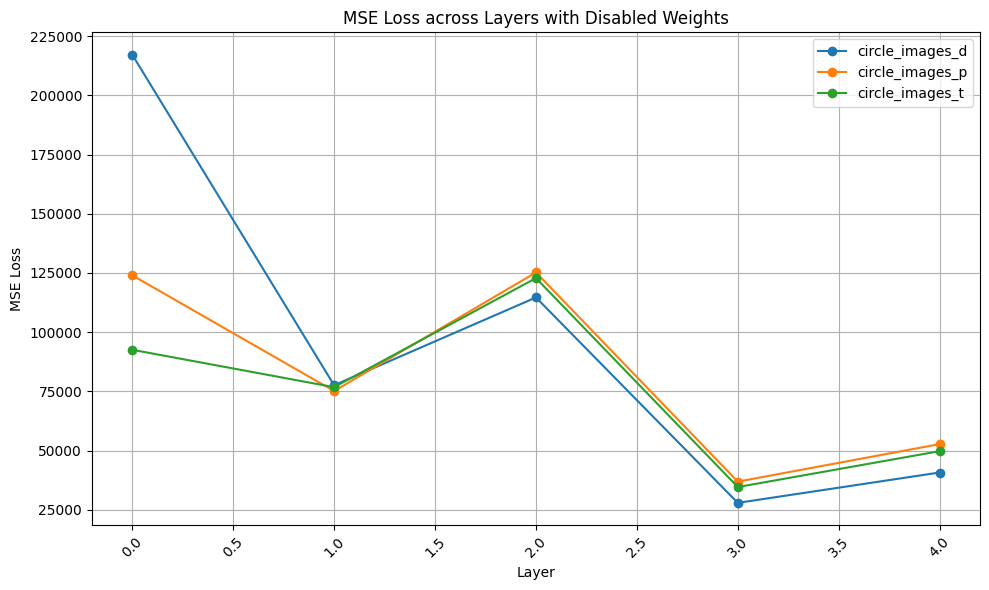

In [10]:

import matplotlib.pyplot as plt

# Extract layer names and MSE Loss values for plotting
layers = list(results['circle_images_d'].keys())
mse_d = [results['circle_images_d'][layer] for layer in layers]
mse_p = [results['circle_images_p'][layer] for layer in layers]
mse_t = [results['circle_images_t'][layer] for layer in layers]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(layers, mse_d, label='circle_images_d', marker='o')
plt.plot(layers, mse_p, label='circle_images_p', marker='o')
plt.plot(layers, mse_t, label='circle_images_t', marker='o')

# Labeling the plot
plt.xlabel('Layer')
plt.ylabel('MSE Loss')
plt.title('MSE Loss across Layers with Disabled Weights')
plt.legend()
plt.xticks(rotation=45)  # Rotate layer names on x-axis for readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()